<a href="https://colab.research.google.com/github/sayakpaul/PAWS-TF/blob/main/PAWS_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* PAWS reference: https://arxiv.org/pdf/2104.13963.pdf
* Code reference: https://github.com/ayulockin/SwAV-TF/blob/master/initial_notebooks/Building_MultiCropDataset.ipynb

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")

Total training examples: 50000


From the PAWS paper:

> The two large-crops (global views) are generated with scale (0.75, 1.0), and the six small-crops (local views) are generated with scale (0.3, 0.75).

In [ ]:
BS = 64
SIZE_CROPS = [32, 18] # 32: global views, 18: local views
NUM_CROPS = [2, 6]
GLOBAL_SCALE = [0.75, 1.0] 
LOCAL_SCALE = [0.3, 0.75]
AUTO = tf.data.AUTOTUNE

## Multi-crop augmentation

In [ ]:
@tf.function
def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    x = tf.clip_by_value(x, 0, 255)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

@tf.function
def custom_augment(image):        
    image = tf.image.random_flip_left_right(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

@tf.function
def random_resize_crop(image, scale, crop_size):
    # Conditional resizing
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 24
        image = tf.image.resize(image, (image_shape, image_shape))
    # Get the crop size for given scale
    size = tf.random.uniform(shape=(1,), 
                            minval=scale[0]*image_shape, maxval=scale[1]*image_shape, 
                            dtype=tf.float32)
    size = tf.cast(size, tf.int32)[0]
    # Get the crop from the image
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    # Flip and color distortions
    distorted_image = custom_augment(crop_resize)
    return distorted_image

@tf.function
def aug_for_labeled(image, label):
    image = tf.image.random_crop(image, (32, 32, 3))
    distorted_image = custom_augment(image)
    return distorted_image, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)

In [ ]:
trainloaders = tuple()
for i, num_crop in enumerate(NUM_CROPS):
    for _ in range(num_crop):
        if SIZE_CROPS[i] == 32:
            scale = GLOBAL_SCALE
        elif SIZE_CROPS[i] == 18:
            scale = LOCAL_SCALE
        
        trainloader = (
            train_ds
            .map(lambda x: random_resize_crop(x, scale, SIZE_CROPS[i]), 
                 num_parallel_calls=AUTO, deterministic=True)
        )
        trainloaders += (trainloader,)

In [ ]:
# Zipping 
final_trainloader = tf.data.Dataset.zip(trainloaders)

# Final trainloader
final_trainloader = (
    final_trainloader
    .shuffle(BS * 100)
    .batch(64)
    .prefetch(AUTO)
)

In [ ]:
# Shape verfiication
im1, im2, im3, im4, im5, im6, im7, im8 = next(iter(final_trainloader))
print(im1.shape, im2.shape, im3.shape, im4.shape, im5.shape, im6.shape, im7.shape, im8.shape)

(64, 32, 32, 3) (64, 32, 32, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3)


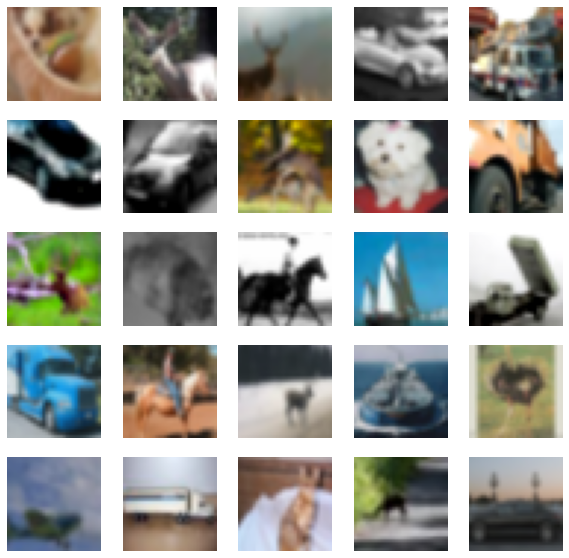

In [ ]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im1[n].numpy().astype("int"))
    plt.axis("off")

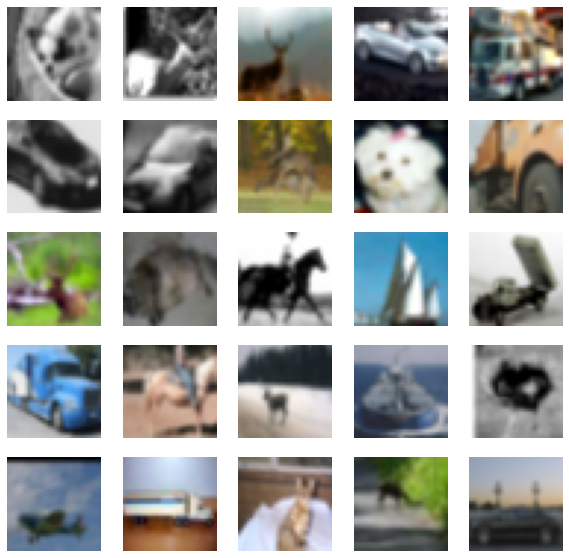

In [ ]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im2[n].numpy().astype("int"))
    plt.axis("off")

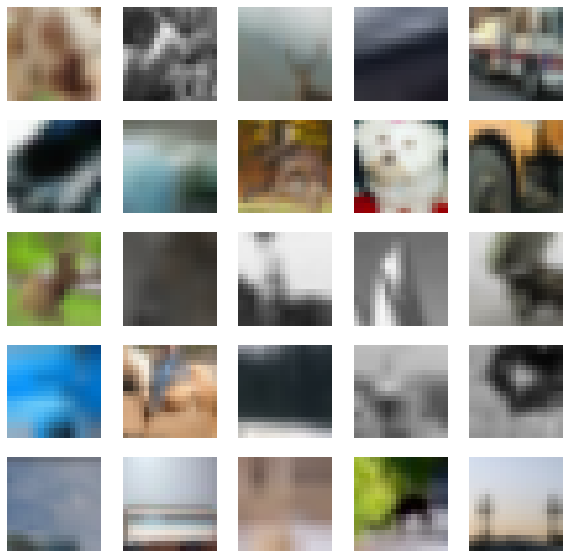

In [ ]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im3[n].numpy().astype("int"))
    plt.axis("off")

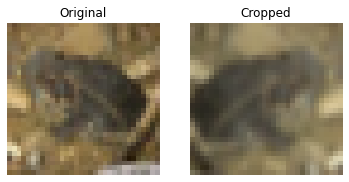

In [ ]:
idx = np.random.choice(len(x_train))
one_image = x_train[idx]
cropped_distorted = random_resize_crop(one_image, GLOBAL_SCALE, crop_size=32)

_, ax = plt.subplots(ncols=2, nrows=1)
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(one_image)
ax[1].imshow(cropped_distorted.numpy().astype("int"))
ax[0].set_title("Original")
ax[1].set_title("Cropped")

plt.show()

## Sampling of labeled samples

From the paper:

>  We first pre-train a network using PAWS on CIFAR10 **with access to 4000 labels** [...] To construct the support mini-batch at each iteration, we also **randomly sample 640 images, comprising 10 classes and 64 images per class**, from the labeled set [...]

In [ ]:
SUPPORT_BS = 160

Because of computational constraints, we are reducing the original batch size (for the unlabeled images) to 64 instead of 256. So, scaling this to determine the batch size for the support samples we have:

$$(64 / 256) * 640 = 160$$

This means having 16 images from each class per batch. 

In [ ]:
sampled_idx = np.random.choice(len(x_train), 4000)
sampled_train, sampled_labels = x_train[sampled_idx], y_train[sampled_idx].squeeze()
print(sampled_train.shape, sampled_labels.shape)

(4000, 32, 32, 3) (4000,)


In [ ]:
def support_sampler():
    idxs = []
    for class_id in np.arange(0, 10):
        subset_labels = sampled_labels[sampled_labels == class_id] 
        random_sampled = np.random.choice(len(subset_labels), 16)
        idxs.append(random_sampled)
    return np.concatenate(idxs)

In [ ]:
def get_support_ds():
    random_balanced_idx = support_sampler()
    temp_train, temp_labels = sampled_train[random_balanced_idx],\
        sampled_labels[random_balanced_idx]
    support_ds = tf.data.Dataset.from_tensor_slices((temp_train, temp_labels))
    support_ds = (
        support_ds
        .shuffle(SUPPORT_BS)
        .map(aug_for_labeled, num_parallel_calls=AUTO)
        .batch(SUPPORT_BS)
    )
    return support_ds

In [ ]:
sample_support_ds = get_support_ds()
support_images, support_labels = next(iter(sample_support_ds))
print(support_images.shape, support_labels.shape)

(160, 32, 32, 3) (160,)


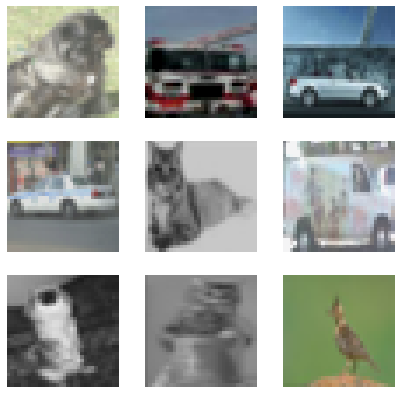

In [ ]:
plt.figure(figsize=(7, 7))
for i, image in enumerate(support_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")